[INFO] Using dummy headlines (scrape failed or too few items).

=== Logistic Regression (heuristic labels) ===
              precision    recall  f1-score   support

    negative      0.988     1.000     0.994       159
    positive      1.000     0.978     0.989        91

    accuracy                          0.992       250
   macro avg      0.994     0.989     0.991       250
weighted avg      0.992     0.992     0.992       250


=== Top words per cluster ===
Cluster 0: ['reduction', 'methane', 'emissions', 'waste', 'plans', 'america']
Cluster 1: ['supply', 'transparency', 'chain', 'america', 'north', 'remain']
Cluster 2: ['green', 'projects', 'hydrogen', 'ai', 'models', 'america']
Cluster 3: ['zero', 'targets', 'net', 'america', 'africa', 'partners']
Cluster 4: ['america', 'energy', 'india', 'efforts', 'recycling', 'battery']


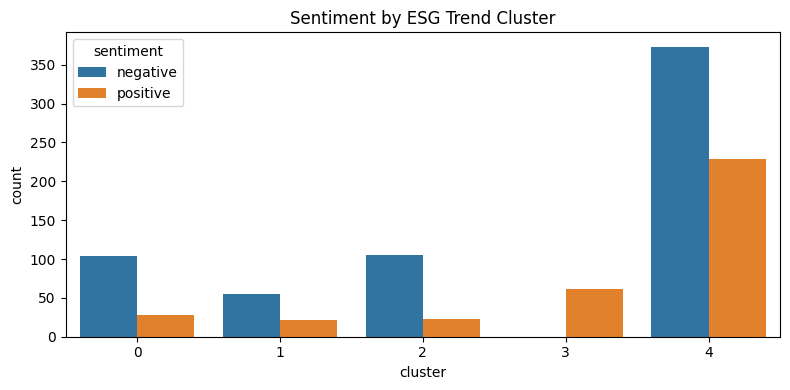

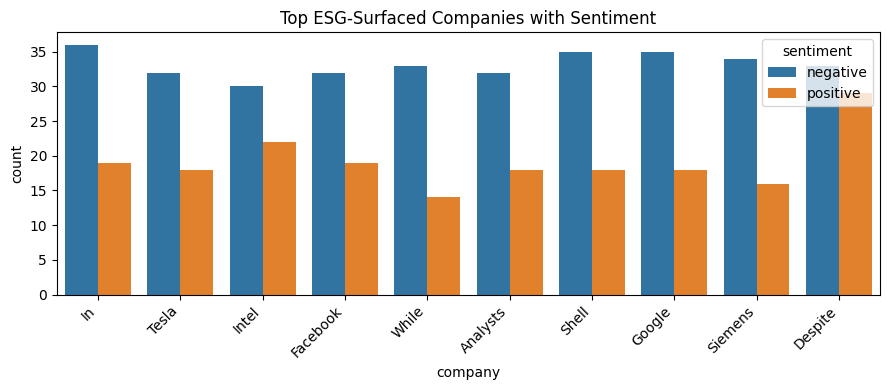

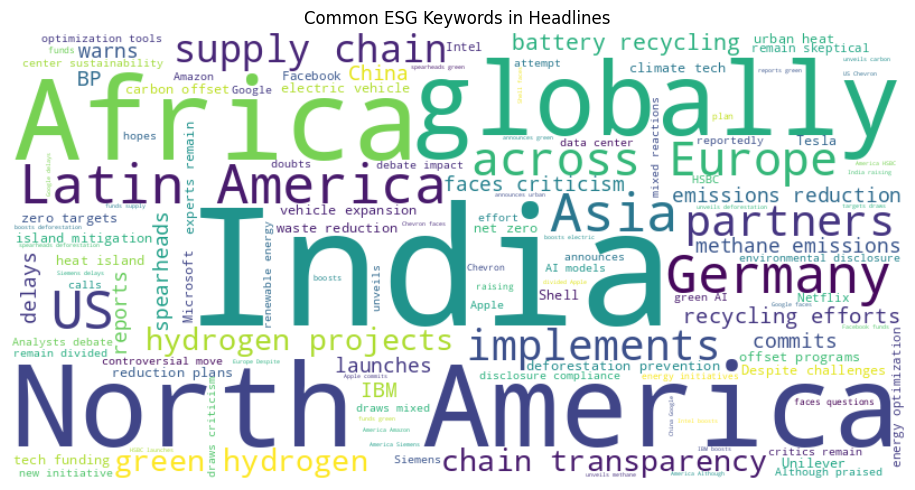

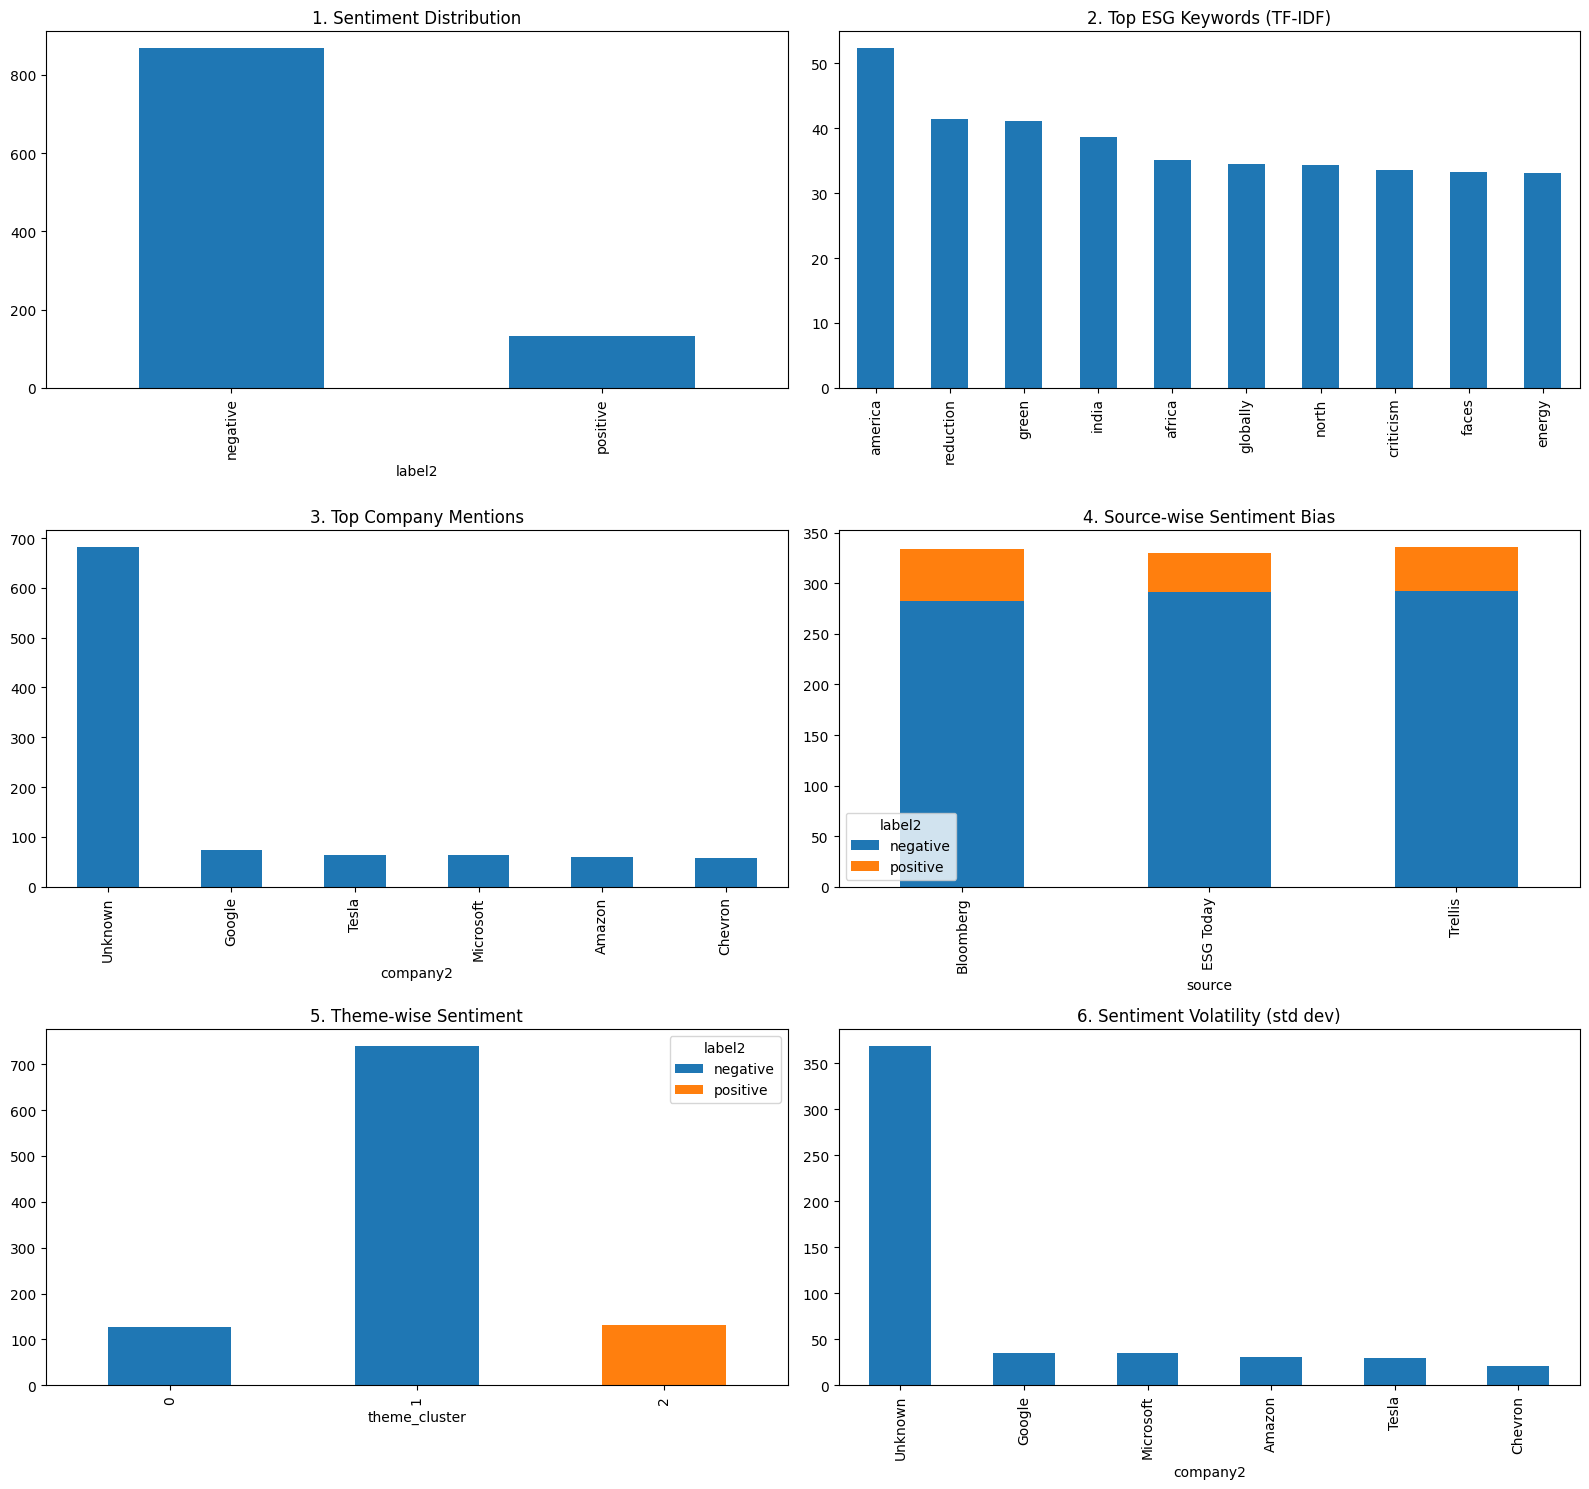

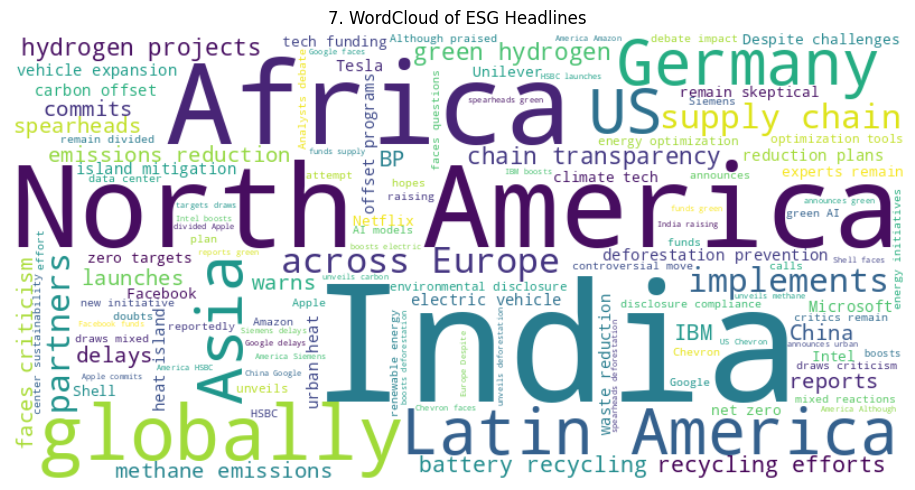


=== Sample rows ===
                                                                                   headline    label sentiment  cluster company   label2 predicted  theme_cluster    source company2
            In a controversial move, Tesla implements urban heat island mitigation in India negative  negative        4      In negative  negative              1 Bloomberg    Tesla
                                   Tesla implements urban heat island mitigation in Germany negative  negative        4   Tesla negative  negative              1   Trellis    Tesla
   Tesla reportedly partners with net-zero targets in Africa, raising both hopes and doubts positive  positive        3   Tesla negative  negative              1 ESG Today    Tesla
Chevron reportedly unveils green hydrogen projects in the US, raising both hopes and doubts negative  negative        2 Chevron negative  negative              0 ESG Today  Chevron
                                        BP warns about methane emissions r

In [12]:

import os
import re
import random
import warnings
from dataclasses import dataclass
from typing import List, Tuple

import requests
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

warnings.filterwarnings("ignore", category=FutureWarning)

# ---------------------------
# Configuration flags
# ---------------------------
USE_DUMMY_IF_SCRAPE_FAILS = True
RUN_TRANSFORMERS = False       # set True if HuggingFace sentiment (downloads model)
RANDOM_STATE = 42

# ---------------------------
# Data classes
# ---------------------------
@dataclass
class ScrapeConfig:
    url: str = "https://www.bloomberg.com/green"
    headers: dict = None
    timeout: int = 10

    def __post_init__(self):
        if self.headers is None:
            self.headers = {"User-Agent": "Mozilla/5.0"}


# ---------------------------
# Utilities
# ---------------------------
def safe_get(url: str, headers: dict, timeout: int) -> requests.Response | None:
    try:
        resp = requests.get(url, headers=headers, timeout=timeout)
        if resp.status_code == 200 and resp.content:
            return resp
        return None
    except Exception:
        return None


def parse_headlines_bloomberg(soup: BeautifulSoup) -> List[str]:
    """
    Bloomberg is dynamic and layout may change.
    So I will upload a new version with Selenium driver
    """
    candidates = set()

    for div in soup.find_all("div", attrs={"data-testid": "headline"}):
        span = div.find("span")
        if span:
            text = span.get_text(strip=True)
            if text:
                candidates.add(text)

    for h in soup.find_all(["h2", "h3"]):
        txt = h.get_text(" ", strip=True)
        if txt and 5 < len(txt) < 200:
            candidates.add(txt)

    # Remove extremely short or clearly non-headline strings
    cleaned = [h for h in candidates if any(c.isalpha() for c in h) and len(h.split()) >= 3]
    return sorted(cleaned)


def build_dummy_df(noise_level=0.5) -> pd.DataFrame:
    import random
    import pandas as pd

    # Base clean template
    base_templates = [
        "{company} {action} {subject} {location}",
    ]

    # Noisy / realistic / ambiguous templates
    noisy_templates = [
        "Despite challenges, {company} {action} {subject} {location}",
        "{company} {action} {subject}, but experts remain skeptical {location}",
        "{company}'s attempt to {action} {subject} draws mixed reactions {location}",
        "{company} {action} what it calls a new initiative on {subject} {location}",
        "{company} faces questions over its plan to {action} {subject} {location}",
        "In a controversial move, {company} {action} {subject} {location}",
        "While critics remain divided, {company} {action} {subject} {location}",
        "{company} reportedly {action} {subject} {location}, raising both hopes and doubts",
        "Analysts debate impact as {company} {action} {subject} {location}",
        "Although praised by some, {company}'s effort to {action} {subject} draws criticism {location}"
    ]

    # Vocabulary pools
    companies = ["Microsoft", "Amazon", "Tesla", "Chevron", "Google", "Facebook", "Apple", "IBM", "Intel", "Netflix", "Shell", "BP", "Siemens", "HSBC", "Unilever"]
    actions = ["boosts", "launches", "announces", "faces criticism over", "funds", "warns about", "unveils", "commits to", "reports", "partners with", "spearheads", "implements", "delays"]
    subjects = [
        "renewable energy initiatives", "climate tech funding", "carbon offset programs", "methane emissions reduction",
        "battery recycling efforts", "data center sustainability", "green AI models", "supply chain transparency",
        "urban heat island mitigation", "waste reduction plans", "deforestation prevention", "electric vehicle expansion",
        "net-zero targets", "energy optimization tools", "environmental disclosure compliance", "green hydrogen projects"
    ]
    locations = ["across Europe", "in India", "in North America", "globally", "in Asia", "in Africa", "in Latin America", "in China", "in the US", "in Germany"]

    # Configurable size and noise
    total = 1000
    n_noisy = int(noise_level * total)
    n_clean = total - n_noisy

    random.seed(42)
    clean_headlines = [
        random.choice(base_templates).format(
            company=random.choice(companies),
            action=random.choice(actions),
            subject=random.choice(subjects),
            location=random.choice(locations)
        )
        for _ in range(n_clean)
    ]

    noisy_headlines = [
        random.choice(noisy_templates).format(
            company=random.choice(companies),
            action=random.choice(actions),
            subject=random.choice(subjects),
            location=random.choice(locations)
        )
        for _ in range(n_noisy)
    ]

    all_headlines = clean_headlines + noisy_headlines
    random.shuffle(all_headlines)

    return pd.DataFrame(all_headlines, columns=["headline"])



def make_labels_rule_based(df: pd.DataFrame, col: str = "headline") -> pd.Series:
    """
    Very naive keyword heuristic for demo/testing.
    """
    pos_kw = ("boost", "fund", "funds", "launch", "optim", "reduce", "target", "recycle", "invest", "progress")
    def lab(h: str) -> str:
        hlow = h.lower()
        return "positive" if any(k in hlow for k in pos_kw) else "negative"
    return df[col].fillna("").map(lab)


def safe_train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE):
    """
    Handles small/imbalanced datasets: if stratified split fails, fallback to non‑stratified.
    """
    try:
        return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    except ValueError:
        return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=None)


def top_terms_per_cluster(kmeans: KMeans, vectorizer: CountVectorizer | TfidfVectorizer, topn: int = 8) -> List[Tuple[int, List[str]]]:
    centers = kmeans.cluster_centers_
    vocab = np.array(vectorizer.get_feature_names_out())
    out = []
    for i in range(centers.shape[0]):
        idx = np.argsort(centers[i])[-topn:][::-1]
        out.append((i, vocab[idx].tolist()))
    return out


def extract_company_simple(text: str) -> str:
    """
    Simple capitalized-phrase heuristic (1–2 words).
    I will replace later with NER for real use (spacy/transformers).
    """
    matches = re.findall(r"\b[A-Z][a-z]+(?: [A-Z][a-z]+)?\b", text)
    return matches[0] if matches else "Unknown"


# ---------------------------
# Main pipeline
# ---------------------------
def main():
    # 1) Get headlines (scrape or dummy)
    cfg = ScrapeConfig()
    df = None

    resp = safe_get(cfg.url, cfg.headers, cfg.timeout)
    if resp is not None:
        soup = BeautifulSoup(resp.content, "html.parser")
        headlines = parse_headlines_bloomberg(soup)
        if len(headlines) >= 10:
            df = pd.DataFrame(headlines, columns=["headline"])

    if df is None and USE_DUMMY_IF_SCRAPE_FAILS:
        print("[INFO] Using dummy headlines (scrape failed or too few items).")
        df = build_dummy_df()

    if df is None or df.empty:
        raise RuntimeError("No headlines available. Aborting.")

    # 2) Heuristic labels (for testing)
    df["label"] = make_labels_rule_based(df, "headline")

    # 3) Train/valid split + TF-IDF
    X_text = df["headline"].astype(str)
    y = df["label"].astype(str)

    X_train, X_test, y_train, y_test = safe_train_test_split(X_text, y, test_size=0.25)

    tfidf = TfidfVectorizer(stop_words="english", max_features=2000)
    X_train_vec = tfidf.fit_transform(X_train)
    X_test_vec = tfidf.transform(X_test)

    # 4) Logistic Regression
    clf = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, solver="liblinear")
    clf.fit(X_train_vec, y_train)
    y_pred = clf.predict(X_test_vec)
    print("\n=== Logistic Regression (heuristic labels) ===")
    print(classification_report(y_test, y_pred, digits=3))

    # 5) Optional: HF Transformers sentiment (can be slow on first run)
    if RUN_TRANSFORMERS:
        try:
            from transformers import pipeline
            sentiment_pipeline = pipeline("sentiment-analysis")
            df["sentiment"] = df["headline"].apply(lambda x: sentiment_pipeline(x)[0]["label"])
        except Exception as e:
            print(f"[WARN] Transformers sentiment failed: {e}")
            df["sentiment"] = "UNKNOWN"
    else:
        # Map our heuristic to a "sentiment" column for downstream plotting
        df["sentiment"] = df["label"]

    # 6) Clustering (CountVectorizer so centroids are interpretable as word counts)
    cvec = CountVectorizer(stop_words="english", min_df=1)
    X_counts = cvec.fit_transform(df["headline"].astype(str))

    kmeans = KMeans(n_clusters=min(5, max(2, len(df) // 4)), n_init=10, random_state=RANDOM_STATE)
    clusters = kmeans.fit_predict(X_counts)
    df["cluster"] = clusters

    print("\n=== Top words per cluster ===")
    for cid, words in top_terms_per_cluster(kmeans, cvec, topn=6):
        print(f"Cluster {cid}: {words}")

    # 7) Company extraction (simple)
    df["company"] = df["headline"].apply(extract_company_simple)

    # 8) Some basic visuals
    # (Guard for tiny datasets)
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x="cluster", hue="sentiment")
    plt.title("Sentiment by ESG Trend Cluster")
    plt.tight_layout()
    plt.show()

    # Top companies
    top_companies = df["company"].value_counts().head(10).index
    plt.figure(figsize=(9, 4))
    sns.countplot(data=df[df["company"].isin(top_companies)], x="company", hue="sentiment")
    plt.xticks(rotation=45, ha="right")
    plt.title("Top ESG‑Surfaced Companies with Sentiment")
    plt.tight_layout()
    plt.show()

    # 9) WordCloud
    text_blob = " ".join(df["headline"].astype(str).tolist())
    if text_blob.strip():
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_blob)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title("Common ESG Keywords in Headlines")
        plt.tight_layout()
        plt.show()

    # 10) Extended example (TF-IDF keywords, simulated source bias, etc.)
    tfidf_full = TfidfVectorizer(stop_words="english")
    X_full = tfidf_full.fit_transform(df["headline"])

    # Dummy re‑label via KMeans (2 clusters) to simulate labels -> map to pos/neg
    km2 = KMeans(n_clusters=2, n_init=10, random_state=RANDOM_STATE).fit(X_full)
    mapped = pd.Series(km2.labels_).map({0: "negative", 1: "positive"})
    # If mapping collapses to one class, randomize a bit to avoid plotting/fit issues
    if mapped.nunique() < 2:
        alt = ["negative", "positive"]
        mapped = pd.Series([random.choice(alt) for _ in range(len(df))])
    df["label2"] = mapped

    # Train LR on TF-IDF with these labels
    clf2 = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, solver="liblinear")
    clf2.fit(X_full, df["label2"])
    df["predicted"] = clf2.predict(X_full)

    # Top keywords
    tfidf_df = pd.DataFrame(X_full.toarray(), columns=tfidf_full.get_feature_names_out())
    top_keywords = tfidf_df.sum().sort_values(ascending=False).head(10)

    # 3‑cluster themes
    km3 = KMeans(n_clusters=min(3, max(2, len(df) // 5)), n_init=10, random_state=RANDOM_STATE).fit(X_full)
    df["theme_cluster"] = km3.labels_

    # Simulated source bias
    rng = np.random.default_rng(RANDOM_STATE)
    choices = ["Bloomberg", "ESG Today", "Trellis"]
    df["source"] = rng.choice(choices, size=len(df))
    source_sentiment = df.groupby("source")["label2"].value_counts().unstack().fillna(0)

    # Simulated company mentions
    companies = ["Microsoft", "Amazon", "Google", "Tesla", "Chevron", "Meta"]
    def pick_company(h):
        hlow = h.lower()
        for c in companies:
            if c.lower() in hlow:
                return c
        return "Unknown"
    df["company2"] = df["headline"].apply(pick_company)
    company_mentions = df["company2"].value_counts().head(10)

    # Theme sentiment
    theme_sentiment = df.groupby("theme_cluster")["label2"].value_counts().unstack().fillna(0)

    # Sentiment volatility (std by company)
    sentiment_volatility = (
        df.groupby("company2")["label2"]
        .value_counts()
        .unstack()
        .fillna(0)
        .std(axis=1)
        .sort_values(ascending=False)
    )

    # Composite plots
    fig, axs = plt.subplots(3, 2, figsize=(16, 15))
    df["label2"].value_counts().plot(kind="bar", ax=axs[0, 0], title="1. Sentiment Distribution")
    top_keywords.plot(kind="bar", ax=axs[0, 1], title="2. Top ESG Keywords (TF‑IDF)")
    company_mentions.plot(kind="bar", ax=axs[1, 0], title="3. Top Company Mentions")
    source_sentiment.plot(kind="bar", stacked=True, ax=axs[1, 1], title="4. Source‑wise Sentiment Bias")
    theme_sentiment.plot(kind="bar", stacked=True, ax=axs[2, 0], title="5. Theme‑wise Sentiment")
    sentiment_volatility.plot(kind="bar", ax=axs[2, 1], title="6. Sentiment Volatility (std dev)")
    plt.tight_layout()
    plt.show()

    # Bonus wordcloud (again on full text)
    if text_blob.strip():
        wc2 = WordCloud(width=800, height=400, background_color="white").generate(text_blob)
        plt.figure(figsize=(10, 5))
        plt.imshow(wc2, interpolation="bilinear")
        plt.axis("off")
        plt.title("7. WordCloud of ESG Headlines")
        plt.tight_layout()
        plt.show()

    # Final peek at the DataFrame
    print("\n=== Sample rows ===")
    print(df.head(10).to_string(index=False))


if __name__ == "__main__":
    main()
